# 1. Zentrale Grenzwertsätze für deterministische dynamische Systeme 

Ziel: Theorie und numerische Experimente zum Zentralen Grenzwertsatz für deterministische dynamische Systeme. (Evtl. als proof of concept für weitere derartige Notebooks: Ergodensätze, Mischungseigenschaften, Beispiele für dynamische Systeme,...) 

Der hier verwendete Code basiert auf der Arbeit von Sebastian Albrecht und Daniel Fischer. Die theoretische Grundlage ist https://perso.univ-rennes1.fr/sebastien.gouezel/articles/lausanne_gouezel.pdf. 

## 1.1 Grundlagen

Wir starten damit, die notwendigen Bibliotheken zu importieren.

In [1]:
 %matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rcParams
from IPython.display import HTML

# To fix some problems: 
rcParams['animation.writer'] = 'avconv'

Nun wollen wir ein paar einfache Beispiel von dynamischen Systemen definieren und zunächst einmal die Graphen der Transformationen plotten, um ein Gefühl zu entwickeln. 

In [3]:
# TODO: Den Erklärenden Text verbessern und auslagern. 

# Angle doubling: x -> 2x mod 1
# Beachte: Multiplikation mit 2 ist numerisch nicht sehr stabil, daher multiplizieren wir hier nur "fast" mit zwei. 
def angleDoubling(x):
    return np.mod(1.9999999999 * x, 1.)

# Eine leicht modifizierte Version der angle doubling map 
# bei der wir mit dem Parameter alpha das Minimum der Ableitung
# modifizieren können (bspw. um die Abbildung nicht expansiv zu machen)

def modifiedAngleDoubling(x, alpha = 0.9):
    y = 1.9999999999 * x - alpha * 0.5 / np.pi * np.sin(2. * np.pi * x)
    return np.mod(y , 1.)

# Die folgende Transformation liefert uns ein Beispiel von "Intermittenz".
# Dadurch, dass die Ableitung im Punkt 0 genau 1 ist, 
# schaut die Transformation lokal fast wie die Identität aus. 
# Startet man eine Trajektorie nahe an der 0 dauert es daher
# sehr lange, bis man von dort entkommt. 

def intermittentMap(x):
    return np.where(x <= 0.5, x/(1-x), 2*x - 1)

# Leicht modifizierte Version,
# die die Voraussetzungen nun ganz knapp erfüllt.  
def slowBranch(x):
    return np.where(x <= 0.5, x + 0.001 * x/(0.501-x), 2*x - 1)

Nun wollen wir uns einmal die Funktionsgraphen dieser Transformationen anschauen. 

In [4]:
# TODO 

## 1.2 Propagation einer Punktwolke

Nun wollen wir eine Funktion definieren, mit der wir die Propagation einer Punktwolke mittels einer gegebenen Transformation berechnen können. 

In [5]:
def compute_dynamic(start, num_steps, sys = modifiedAngleDoubling):
    trajectories = np.zeros((num_steps, start.shape[0]))
    trajectories[0] = start
    for i in range(1,num_steps):
        trajectories[i] = sys(trajectories[i-1])
    return trajectories

# TODO: Erklärungen/Kommentare zum Code. 

## 1.3 Observablen

Um uns mit dem zentralen Grenzwertsatz zu beschäftigen müssen wir nun noch ein paar Observablen einführen, für die wir das Verhalten der (normalisierten) Partialsummen untersuchen wollen. 

In [6]:
def id_(x):
    return x

def cos(x):
    return np.cos(2 * np.pi * x)

def poly(x):
    return x**4 - 1.258 * x**3

def exp(x):
    return np.exp(x)

def ln(x):
    epsilon = 0.2
    return np.log(x + epsilon)

# Geshifteter Absolutbetrag: 
def non_C1(x):
    return np.abs(x - 0.5)

# Indikatorfunktion: 
def non_C0(x):
    epsilon = 0.025 
    return np.where( np.mod(x, 0.1) < epsilon, 0., 1.)

## 1.4 Die Partialsummen
Nun können wir die Partialsummen für eine Transformation T, 
eine Observable f, und eine gegebene Menge an Startpunkten berechnen.  

In [7]:
def compute_Sn(trajectories, obs, num_steps = None):
    # ermittle num_steps und num_points
    if num_steps == None: num_steps = trajectories.shape[0]
    num_points = trajectories.shape[1]
    
    # Berechne Wert der Observable für jeden Punkt nach jedem Schritt 
    obs_values = obs(trajectories)
    # Berechne Partialsummen über alle vorangegangenen Schritte für jeden Punkt
    Sn = np.cumsum(obs_values, axis = 0)
    
    # Subtrahiere in jedem Schritt den Mittelwert der Partialsummen aller Punkte in diesem Schritt
    mean = np.repeat( Sn.mean(axis = 1) , num_points )
    mean = np.reshape( mean, (num_steps,num_points) )
    Sn -= mean
    
    # Skaliere in jedem Schritt die Partialsummen für alle Punkte mit dem Faktor: 1/np.sqrt(n)
    for n in range(num_steps):
        Sn[n] = 1./np.sqrt(1+n) * Sn[n]

    return Sn

## 1.5 Code für die Animationen

Nach dieser Vorarbeit können wir uns nun mit den eigentlichen Animationen beschäftigen. Die Hauptarbeit übernimmt hierbei die folgende Funktion. 


In [8]:
# Animation der Folge von Partialsummen
# input: sys - Abbildung; start - Punktwolke: np.array shape [num_points]; num_steps - Anzahl Schritte; 
#        obs - list of observable(s); num_frames - Anzahl Frames für Animation
# output: Animation - FuncAnimation Instanz
def anim_limit_thm(sys, start, obs = [id_, cos, exp, ln], num_steps = 3000, num_frames = 100, 
                   num_bins = 51, sys_name = "", 
                   obs_names = ["Identität", "Kosinus", "Exponential", "Logarithmus"], 
                   title = "Grenzwertsatz (für verschiedene Observablen)"):
    
    # Berechnung der Gouezel Folgen
    sequences = []
    trajectories = compute_dynamic(start, num_steps, sys)
    for f in obs:
        sequences.append( compute_Sn(trajectories, f) )
    
    sequences = np.array(sequences)
    
    # Vorbereitung der Plots
    num_plots = len(sequences)
    num_rows = int( np.sqrt(num_plots) )
    num_cols = int( np.ceil( num_plots / num_rows ) )
    fig = plt.figure()
    fig.subplots(nrows = num_rows, ncols = num_cols) 
    fig.suptitle(title)
    fig.text(0.05, 0.02, sys_name, fontsize = "large")

    # Festlegung der Frames die in der Animation gezeigt werden. Da die
    # ersten Folgenglieder deutlich interessanter sind, wächst der Abstand 
    # zwischen den in der Animation gezeigten Folgengliedern exponentiell.
    steps = np.unique( np.geomspace(1, num_steps, num_frames, 
                                    endpoint = True, dtype = int) ) - 1

    # Erstellung der Animation. Die Argumente >fargs< werden an die update 
    # function >update_gouezel_anim< übergeben.
    anim = animation.FuncAnimation(fig, update_limit_thm_anim, interval=250, 
                                   frames = steps.size, 
                                   fargs = (sequences, steps, num_bins, obs_names), 
                                   repeat = False)
    return anim

Als Hilfsmittel benötigen wir nun noch die folgende Funktion. 

In [9]:
# Update der Frames in der Gouezel Sequence Animation. Das erste Argument >i<
# wird intern von FuncAnimation weitergegeben. Die letzteren drei Argumente
# müssen bei der Initialisierung der FuncAnimation Instanz angegeben werden:
# >sequences< ist eine Liste von Numpy Arrays, die jeweils die Gouezel Reihe
# für eine spezielle Funktion enthalten, >steps< sind die Indizes der
# Folgenglieder, die in der Animation geplotted werden, >labels< ist die 
# Liste der Titel der einzelen Plots in der Animation.
def update_limit_thm_anim(i, sequences, steps, num_bins, labels):
    
    print(steps[i], end = " ")

    fig = plt.gcf()
    
    x_lim_left = abs( sequences[:,-1,:].min() )
    x_lim_right = abs( sequences[:,-1,:].max() )
    x_lim = max( x_lim_left, x_lim_right )
    
    y_lim = sequences.shape[2] * 4 / num_bins
    
    for j, ax in enumerate(fig.axes):
        ax.clear()
        
        ax.set_xlim(left = -x_lim, right = x_lim)
        ax.set_ylim(bottom = - 0.1 * y_lim, top = y_lim)
        ax.set_xticks([-x_lim, -0.5 * x_lim, 0, 0.5 * x_lim, x_lim])
        ax.set_xticklabels(["","", "", "", ""])
        ax.set_yticks([])
        ax.set_title(labels[j])
        
        ax.hist( sequences[j][steps[i]], bins = num_bins)
    
    return fig

## 1.6 Animationen
Nachdem die harte Arbeit nun gemacht ist, können wir uns endlich
dem schönen Teil widmen. 

0 0 1 2 3 4 5 6 7 8 10 11 12 14 16 18 20 22 25 28 32 35 40 44 50 56 62 69 78 87 97 108 121 135 151 169 188 210 235 262 292 326 364 406 453 506 565 630 703 784 875 976 1089 1215 1356 1512 1687 1882 2100 2343 2613 2915 3252 3628 4047 4515 5036 5618 6267 6991 7798 8699 9704 10825 12075 13469 15025 16761 18696 20856 23264 25951 28948 32292 36021 40181 44822 49998 

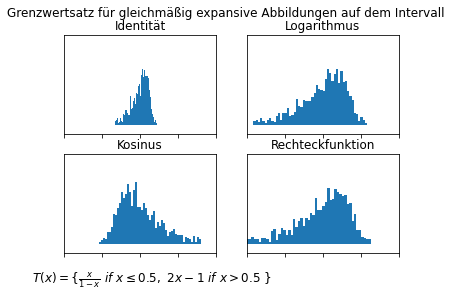

In [10]:
# Erstelle neue Animation
num_points = 1000
start = np.random.random(num_points)
local_start = np.random.normal(0.5, 0.01, size = num_points) 
#anim = anim_limit_thm(doubling_sys, start, obs = [cos,ln,non_C1,non_C0], num_steps = 400, num_frames = 60,
#                      sys_name = r"$T = 2x \ \operatorname{mod} \ 1$",
#                      obs_names = ["Kosinus", "Logarithmus", "Betrag", "Rechteckfunktion"],
#                      title = "Grenzwertsatz für gleichmäßig expansive Abbildungen auf dem Intervall")
#anim = anim_limit_thm(lambda x: modified_doubling_sys(x, alpha = 0.99),
#                      start, obs = [id_,ln,cos,non_C0], num_steps = 3000, num_frames = 100,
#                      sys_name = r"$T(x) = [2x - \frac{0.99}{2 \pi} \ \sin(2 \pi x)] \ \operatorname{mod} \ 1$", 
#                      obs_names = ["Identität", "Logarithmus", "Kosinus", "Rechteckfunktion"], 
#                      title = "Grenzwertsatz für gleichmäßig expansive Abbildungen auf dem Intervall")

# use only 1000 points for 50000 steps!!!
anim = anim_limit_thm(intermittentMap, start, obs = [id_,ln,cos,non_C0], num_steps = 50000, num_frames = 100,
                      sys_name = r"$T(x) = \{ \frac{x}{1-x} \ if \ x \leq 0.5, \ 2x - 1 \ if \ x > 0.5 \ \}$",
                      obs_names = ["Identität", "Logarithmus", "Kosinus", "Rechteckfunktion"],
                      title = "Grenzwertsatz für gleichmäßig expansive Abbildungen auf dem Intervall")

HTML(anim.to_jshtml())

# TODO:
# - Verhindern, dass er alle timesteps aufzählt. 
# - vll noch bisschen größer machen. 

# 2. Donsker-type Theorem

Weiterführender Aspekt: Donsker-type Theorem im Setting von deterministischen dynamischen Systemen. (Note to myself: Evtl. ähnliche Simulationen wie auf Blatt2, Stochastische Analysis mit rauszoomen etc: http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/). 

Wir wollen nun Prozese von der Form $$X^{(n)}_t := \frac{1}{\sqrt{n}}S_{\lfloor n t \rfloor}$$ für $$S_n := \sum_{k=0}^{n-1}f\circ T^k$$ untersuchen. Diese sollten (nach entsprechender Normierung!) in Verteilung gegen die Brownsche Bewegung konvergieren. 

## 2.1 Warm-up: Der klassische Satz von Donsker 

TODO: Theoretische Grundlagen zum Satz von Donsker. Kurze Erklärung der Objekte etc.

In [11]:
# TODO: Code 

from numpy import random 

# Wir müssen zunächst Zufallsvariablen erzeugen. 
# Syntax: random.rand(#Samples) erzeugt gleichmäßig auf [0,1] verteilte Zahlen
x = random.rand(1000000)

# Normierung: X -> (X-E[X])/sqrt(Var(X)). 

x = (x-1/2)*np.sqrt(12)

# Partialsummen berechnen: 

partialSums = np.cumsum(x)

# Donskersummen berechnen: 
# Zunächst leeres numpy array anlegen: 
donskerSums = np.zeros((1000,10000))


for n in range(1000): 
    for step in range(10000): 
        t = step/1000
        donskerSums[n,step] = 1/(np.sqrt(n+1))*partialSums[int(n*t)]
    


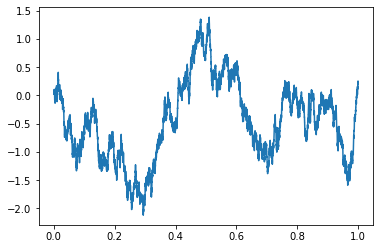

In [12]:
# Plot zum testen ob das soweit passt: 
x = np.linspace(0,1,10000)
plt.plot(x, donskerSums[500])

# Schaut soweit ok aus 

Nun wollen wir das ganze animieren. 

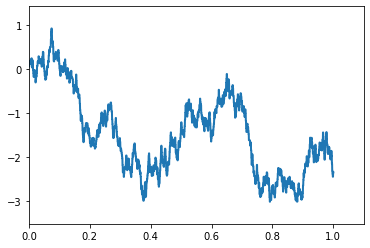

In [19]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 1.1))


line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)


def animateDonsker(n):
    x = np.linspace(0,1,10000)
    y = donskerSums[n]
    ax.set_ylim(np.min(y)-0.5, np.max(y)+0.5)
    line.set_data(x,y)
    return(line,)

# Frames= AnzahlBilder, interval=DelaayZwischenBildern
anim = animation.FuncAnimation(fig, animateDonsker, init_func=init,
                               frames=100, interval=150, blit=True)

HTML(anim.to_jshtml())
    
    
# TODO: Das muss deutlich langsamer werden!!!